# IPL Score Prediction - Inference

This notebook loads the trained IPL score prediction model (`best_ipl_model.pth`) and runs inference on new match data.

## Import Required Libraries

First, let's import the libraries needed for model loading and inference.

In [210]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import json
from datetime import datetime

# Add the parent directory to the path to import model classes
sys.path.append('..')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

## FILE PATH 
inference_path = 'inference/inference.csv'

Using device: cuda


## Define Model Architecture

Define the model architecture that matches the trained model.

In [211]:
class IPLScorePredictor(torch.nn.Module):
    """Neural network model for predicting IPL match scores.
    
    This model uses LSTM layers to process sequence data and predict
    final scores and wickets.
    """
    
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3, output_size=2, temperature=1.0):
        """Initialize the model.
        
        Args:
            input_size: Size of input features
            hidden_size: Size of LSTM hidden layers
            num_layers: Number of LSTM layers
            dropout: Dropout probability
            output_size: Size of output (typically 2 for runs and wickets)
            temperature: Controls randomness in predictions (higher = more random)
        """
        super(IPLScorePredictor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.temperature = temperature
        
        # LSTM layers
        self.lstm = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers for prediction
        self.fc1 = torch.nn.Linear(hidden_size, hidden_size // 2)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size // 2, output_size)
        
        print(
            f"Initialized model: input_size={input_size}, "
            f"hidden_size={hidden_size}, num_layers={num_layers}, "
            f"dropout={dropout}, output_size={output_size}, temperature={temperature}"
        )
    
    def forward(self, x, seq_lengths=None):
        """Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
            seq_lengths: Actual sequence lengths for each item in the batch
            
        Returns:
            Predicted scores with runs as direct values and wickets as logits
        """
        batch_size = x.size(0)
        
        # Pack padded sequence if sequence lengths are provided
        if seq_lengths is not None:
            # Pack the sequence to handle variable length sequences efficiently
            from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
            x = pack_padded_sequence(x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.data.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.data.device)
        
        # Forward through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Unpack if we packed earlier
        if seq_lengths is not None:
            out, _ = pad_packed_sequence(out, batch_first=True)
            
            # Use the last valid output for each sequence based on its length
            # Convert seq_lengths to indices tensor of correct type
            indices = (seq_lengths - 1).view(-1, 1).expand(batch_size, self.hidden_size)
            indices = indices.unsqueeze(1).to(torch.int64).to(x.data.device)
            out = out.gather(1, indices).squeeze(1)
        else:
            # Use the output from the last time step if no sequence lengths
            out = out[:, -1, :]
        
        # Forward through fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out) 
        
        return out

## Load Preprocessing Components

Load the preprocessing components (scaler, encoder) needed for feature preparation.

In [212]:
def load_preprocessing_components():
    """Load preprocessing components from pickle files.
    
    Returns:
        Tuple of (numerical_features, scaler, team_encoder)
    """
    try:
        # Load the numerical features list
        with open('./train/numerical_features.pkl', 'rb') as f:
            numerical_features = pickle.load(f)
        print(f"Loaded numerical features: {numerical_features}")
        
        # Load the scaler
        with open('./train/scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        print("Loaded feature scaler successfully")
        
        # Load the team encoder
        with open('./train/team_encoder.pkl', 'rb') as f:
            team_encoder = pickle.load(f)
        print(f"Loaded team encoder with {len(team_encoder.classes_)} classes")
        print(f"Team classes: {team_encoder.classes_}")
        
        return numerical_features, scaler, team_encoder
    except Exception as e:
        print(f"Error loading preprocessing components: {e}")
        return None, None, None

# Load preprocessing components
numerical_features, scaler, team_encoder = load_preprocessing_components()

Loaded numerical features: ['over', 'curr_run_rate', 'req_runrate', 'target_left', 'weighted_run_rate']
Loaded feature scaler successfully
Loaded team encoder with 14 classes
Team classes: ['Chennai Super Kings' 'Delhi Capitals' 'Gujarat Lions' 'Gujarat Titans'
 'Kochi Tuskers Kerala' 'Kolkata Knight Riders' 'Lucknow Super Giants'
 'Mumbai Indians' 'Pune Warriors' 'Punjab Kings' 'Rajasthan Royals'
 'Rising Pune Supergiant' 'Royal Challengers Bengaluru'
 'Sunrisers Hyderabad']


## Load Trained Model

Load the trained model from the saved checkpoint.

In [213]:
def load_trained_model(model_path='./best_ipl_model.pth'):
    """Load a saved model from checkpoint.
    
    Args:
        model_path: Path to the model checkpoint
        
    Returns:
        Loaded model and checkpoint data
    """
    try:
        # Load the checkpoint
        checkpoint = torch.load(model_path, map_location=device,weights_only=False)
        
        # Extract model parameters if available in the checkpoint
        if 'model_params' in checkpoint:
            model_params = checkpoint['model_params']
        else:
            # Default parameters if not in checkpoint
            model_params = {
                'input_size': 7,  # From config.json
                'hidden_size': 64,
                'num_layers': 2,
                'dropout': 0.3,
                'output_size': 2
            }
        
        # Create model instance
        model = IPLScorePredictor(**model_params)
        
        # Load weights
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)  # If checkpoint is just the state dict
        
        # Set model to evaluation mode
        model.eval()
        model = model.to(device)
        
        # Print model details and metrics if available
        print(f"Successfully loaded model from {model_path}")
        if 'epoch' in checkpoint:
            print(f"Model saved at epoch: {checkpoint['epoch']}")
        if 'val_loss' in checkpoint:
            print(f"Validation loss: {checkpoint['val_loss']:.4f}")
        if 'run_mae' in checkpoint:
            print(f"Run MAE: {checkpoint['run_mae']:.4f}")
        if 'wicket_accuracy' in checkpoint:
            print(f"Wicket accuracy: {checkpoint['wicket_accuracy']:.4f}")
        
        return model, checkpoint
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

# Load the model
model, checkpoint = load_trained_model()

Initialized model: input_size=7, hidden_size=64, num_layers=2, dropout=0.3, output_size=2, temperature=1.2
Successfully loaded model from ./best_ipl_model.pth


## Load and Preprocess Input Data

Load the input data from CSV and preprocess it for model inference.

In [214]:
def load_input_data(file_path='inference/inference.csv'):
    """Load input data from CSV file.
    
    Args:
        file_path: Path to the input CSV file
        
    Returns:
        Loaded DataFrame
    """
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        df = pd.read_csv(file_path)
        if df.empty:
            raise ValueError("Input file is empty")
        print(f"Loaded input data with {len(df)} rows")
        print(df.head())
        return df
    except Exception as e:
        print(f"Error loading input data: {e}")
        return None

def preprocess_input_data(df, numerical_features, scaler, team_encoder):
    """Preprocess the input data for model inference.
    
    Args:
        df: Input DataFrame
        numerical_features: List of numerical feature names
        scaler: StandardScaler instance
        team_encoder: LabelEncoder instance
        
    Returns:
        Processed data ready for model input
    """
    try:
        # Create a copy to avoid modifying the original
        df_processed = df.copy()
        
        # Encode teams if they are in string format
        if df_processed['batting_team'].dtype == 'object':
            df_processed['batting_team'] = team_encoder.transform(df_processed['batting_team'])
            df_processed['bowling_team'] = team_encoder.transform(df_processed['bowling_team'])
            print("Encoded team names")
        
        # Check if all required numerical features are in the DataFrame
        missing_features = [feat for feat in numerical_features if feat not in df_processed.columns]
        if missing_features:
            print(f"Warning: Missing numerical features: {missing_features}")
            # Add missing features with default values
            for feat in missing_features:
                df_processed[feat] = 0.0
            print("Added missing features with default values")
        
        # Scale numerical features
        if scaler is not None:
            numerical_data = scaler.transform(df_processed[numerical_features])
            print("Scaled numerical features")
        else:
            numerical_data = df_processed[numerical_features].values
            print("Using unscaled numerical features (no scaler provided)")
        
        return df_processed, numerical_data
    except Exception as e:
        print(f"Error preprocessing input data: {e}")
        return None, None

# Load and preprocess input data
input_df = load_input_data(inference_path)
if input_df is not None:
    processed_df, numerical_data = preprocess_input_data(input_df, numerical_features, scaler, team_encoder)

Loaded input data with 14 rows
   match_id  inning  batting_team  bowling_team  over  season  \
0   1359479       1             7            12     1    2023   
1   1359479       1             7            12     2    2023   
2   1359479       1             7            12     3    2023   
3   1359479       1             7            12     4    2023   
4   1359479       1             7            12     5    2023   

  who_is_batting_first  total_runs  is_wicket  run_rate  target_runs  \
0       Mumbai Indians           2          0      2.00            0   
1       Mumbai Indians           9          0      5.50            0   
2       Mumbai Indians           1          1      4.00            0   
3       Mumbai Indians           5          1      4.25            0   
4       Mumbai Indians           2          0      3.80            0   

   target_left  req_runrate  curr_run_rate  weighted_run_rate  season_year  
0            0          0.0              2               2.00       

## Prepare Data for Model Inference

Organize data for batch inference or sequence inference.

In [215]:
def prepare_model_inputs(df, numerical_data, sequence_mode=True):
    """Prepare inputs for the model in either single instance or sequence mode.
    
    Args:
        df: Processed DataFrame
        numerical_data: Scaled numerical features
        sequence_mode: Whether to prepare sequences by match-inning
        
    Returns:
        Dictionary with model inputs
    """
    inputs = []
    metadata = []
    
    if sequence_mode and 'match_id' in df.columns and 'inning' in df.columns:
        # Group by match_id and inning
        print("Preparing sequence inputs by match and inning")
        grouped = df.groupby(['match_id', 'inning'])
        
        for (match_id, inning), group in grouped:
            # Sort by over to ensure correct sequence
            group = group.sort_values('over')
            
            # Extract indices in numerical_data that correspond to this sequence
            indices = group.index.tolist()
            
            # Get team encodings
            batting_team = group['batting_team'].iloc[0]
            bowling_team = group['bowling_team'].iloc[0]
            
            # Create feature tensor with shape [sequence_length, feature_size]
            sequence_features = []
            for i, idx in enumerate(indices):
                # Combine numerical features with team info
                features = list(numerical_data[i]) + [batting_team, bowling_team]
                sequence_features.append(features)
            
            # Convert to tensor and add to inputs
            sequence_tensor = torch.tensor(sequence_features, dtype=torch.float32).unsqueeze(0)  # Add batch dim
            inputs.append(sequence_tensor)
            
            # Add metadata
            meta = {
                'match_id': match_id,
                'inning': inning,
                'overs': group['over'].tolist(),
                'sequence_length': len(group)
            }
            metadata.append(meta)
        
        print(f"Prepared {len(inputs)} sequences")
    else:
        # Single instance mode
        print("Preparing individual inputs for each row")
        for i in range(len(df)):
            row = df.iloc[i]
            
            # Combine numerical features with team info
            features = list(numerical_data[i]) + [row['batting_team'], row['bowling_team']]
            feature_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0)  # Add batch dim
            inputs.append(feature_tensor)
            
            # Add metadata
            meta = {
                'index': i,
                'over': row['over'] if 'over' in row else None,
                'match_id': row['match_id'] if 'match_id' in row else None,
                'inning': row['inning'] if 'inning' in row else None
            }
            metadata.append(meta)
        
        print(f"Prepared {len(inputs)} individual inputs")
    
    return {
        'inputs': inputs,
        'metadata': metadata
    }

# Prepare model inputs
# Try sequence mode first, fall back to single instance mode if needed
try:
    model_inputs = prepare_model_inputs(processed_df, numerical_data, sequence_mode=True)
except Exception as e:
    print(f"Error preparing sequence inputs: {e}")
    print("Falling back to single instance mode")
    model_inputs = prepare_model_inputs(processed_df, numerical_data, sequence_mode=False)

Preparing sequence inputs by match and inning
Prepared 1 sequences


## Run Model Inference

Use the trained model to make predictions on the input data.

In [216]:
def run_inference(model, inputs, metadata, sequence_mode=True):
    """Run inference with the model on the prepared inputs.
    
    Args:
        model: The trained model
        inputs: List of input tensors
        metadata: List of metadata dictionaries
        sequence_mode: Whether inputs are sequences
        
    Returns:
        Dictionary of predictions
    """
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for i, input_tensor in enumerate(inputs):
            # Move input to device
            input_tensor = input_tensor.to(device)
            
            if sequence_mode:
                # For sequence mode, we need sequence length
                seq_length = torch.tensor([metadata[i]['sequence_length']], dtype=torch.int32).to(device)
                output = model(input_tensor, seq_length)
            else:
                # Ensure input tensor is 3-D: [batch, seq_len, input_size]
                if input_tensor.dim() == 2:
                    input_tensor = input_tensor.unsqueeze(1)  # add sequence dim
                output = model(input_tensor)
            
            # Extract predictions
            run_pred = output[0, 0].item()  # First output value is runs
            wicket_prob = torch.sigmoid(output[0, 1]).item()  # Second output value is wicket probability logit
            wicket_pred = 1 if wicket_prob > 0.5 else 0
            
            # Store predictions with metadata
            pred = {
                **metadata[i],  # Include all metadata
                'predicted_runs': run_pred,
                'predicted_wicket_probability': wicket_prob,
                'predicted_wicket': wicket_pred
            }
            predictions.append(pred)
    
    print(f"Completed inference on {len(inputs)} inputs")
    return predictions

# Run inference
# Determine sequence mode based on model_inputs structure
# Create a test input DataFrame that mimics the expected input format
test_input_df = pd.DataFrame({
    'match_id': [999999],
    'inning': [1],
    'batting_team': ['Mumbai Indians'],
    'bowling_team': ['Chennai Super Kings'],
    'over': [3],
    'curr_run_rate': [8.8],
    'req_runrate': [0],
    'target_left': [0000],
    'weighted_run_rate': [8.5]
})

# Preprocess the test input
processed_test_df, test_numerical_data = preprocess_input_data(
    test_input_df, numerical_features, scaler, team_encoder
)

# Prepare model inputs; use sequence mode if grouping by match_id and inning is possible
test_model_inputs = prepare_model_inputs(processed_test_df, test_numerical_data, sequence_mode=True)
test_sequence_mode = 'sequence_length' in test_model_inputs['metadata'][0] if test_model_inputs['metadata'] else False

# Run inference on the test input
test_predictions = run_inference(model, test_model_inputs['inputs'], test_model_inputs['metadata'], sequence_mode=test_sequence_mode)
print("Test Predictions:", test_predictions)

Encoded team names
Scaled numerical features
Preparing sequence inputs by match and inning
Prepared 1 sequences
Completed inference on 1 inputs
Test Predictions: [{'match_id': np.int64(999999), 'inning': np.int64(1), 'overs': [3], 'sequence_length': 1, 'predicted_runs': 9.215667724609375, 'predicted_wicket_probability': 0.42987313866615295, 'predicted_wicket': 0}]


## Format and Save Results

Format the prediction results and save them to a CSV file.

In [217]:
def format_and_save_results(predictions, output_file='./inference/predictions.csv'):
    """Format predictions and save to a CSV file.
    
    Args:
        predictions: List of prediction dictionaries
        output_file: Path to save the predictions
        
    Returns:
        DataFrame with predictions
    """
    # Convert list of dictionaries to DataFrame
    predictions_df = pd.DataFrame(predictions)
    
    # Add timestamp
    predictions_df['prediction_time'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Round predictions to 2 decimal places
    if 'predicted_runs' in predictions_df.columns:
        predictions_df['predicted_runs'] = predictions_df['predicted_runs'].round(2)
    if 'predicted_wicket_probability' in predictions_df.columns:
        predictions_df['predicted_wicket_probability'] = predictions_df['predicted_wicket_probability'].round(4)
    
    # Save to CSV
    predictions_df.to_csv(output_file, index=False)
    print(f"Saved predictions to {output_file}")
    
    return predictions_df

# Format and save results
predictions_df = format_and_save_results(predictions)

Saved predictions to ./inference/predictions.csv


## Visualize Predictions

Create visualizations of the prediction results.

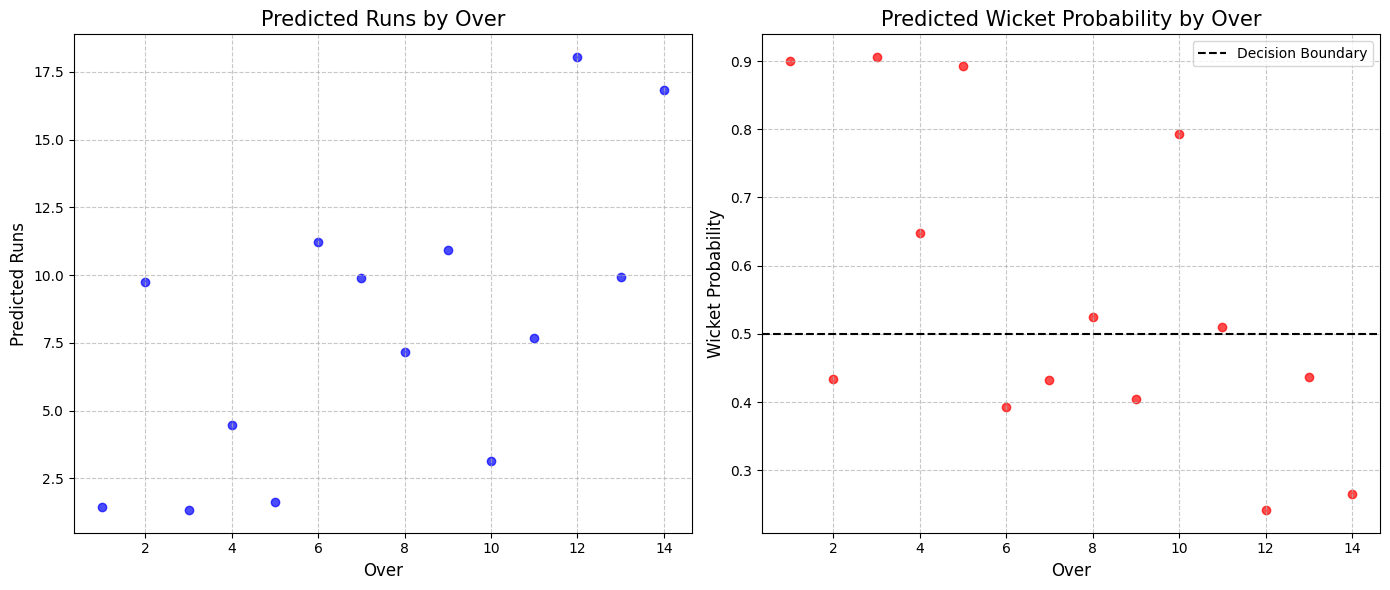

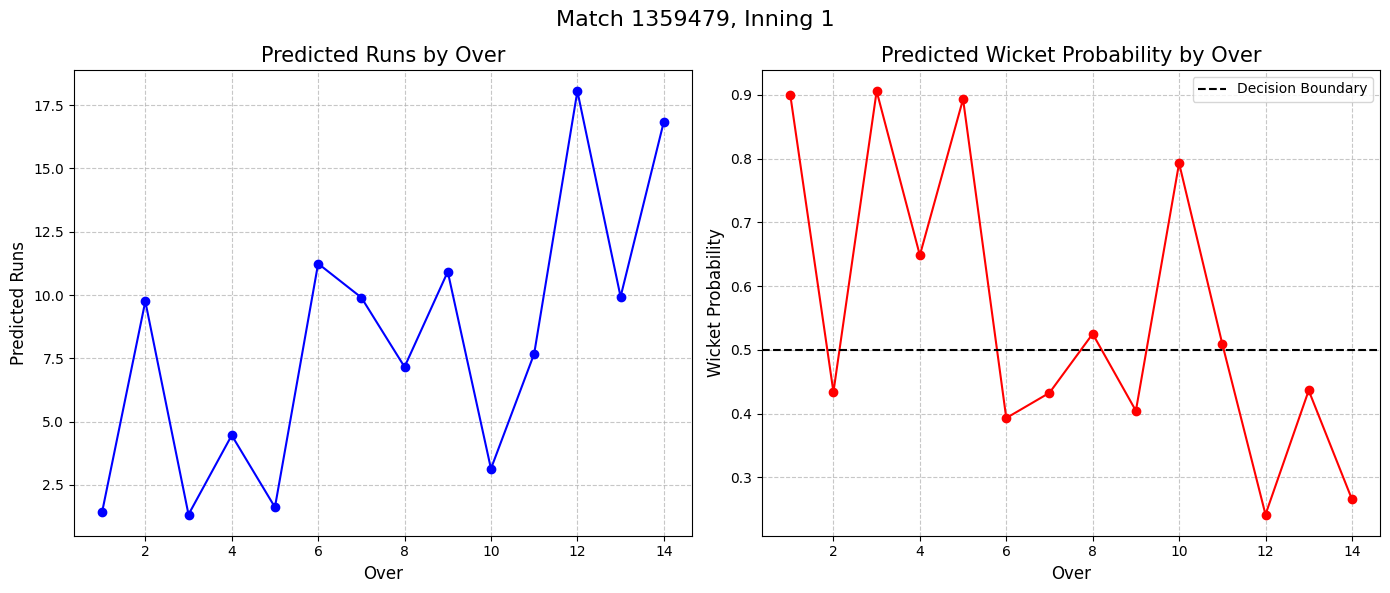

In [222]:
def visualize_predictions(predictions_df):
    """Visualize the prediction results.
    
    Args:
        predictions_df: DataFrame with predictions
    """
    # Check if we have over data for plotting
    if 'over' in predictions_df.columns and len(predictions_df) > 1:
        plt.figure(figsize=(14, 6))
        
        # Plot predicted runs by over
        plt.subplot(1, 2, 1)
        plt.scatter(predictions_df['over'], predictions_df['predicted_runs'], c='blue', alpha=0.7)
        plt.title('Predicted Runs by Over', fontsize=15)
        plt.xlabel('Over', fontsize=12)
        plt.ylabel('Predicted Runs', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Plot wicket probability by over
        plt.subplot(1, 2, 2)
        plt.scatter(predictions_df['over'], predictions_df['predicted_wicket_probability'], c='red', alpha=0.7)
        plt.axhline(y=0.5, color='black', linestyle='--', label='Decision Boundary')
        plt.title('Predicted Wicket Probability by Over', fontsize=15)
        plt.xlabel('Over', fontsize=12)
        plt.ylabel('Wicket Probability', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # If we have match_id and inning data, create per-match plots
        if 'match_id' in predictions_df.columns and 'inning' in predictions_df.columns:
            # Get unique match-inning combinations
            match_innings = predictions_df.groupby(['match_id', 'inning'])
            
            for (match_id, inning), group in match_innings:
                if len(group) <= 1:
                    continue  # Skip if only one observation
                    
                plt.figure(figsize=(14, 6))
                plt.suptitle(f'Match {match_id}, Inning {inning}', fontsize=16)
                
                # Plot predicted runs by over for this match-inning
                plt.subplot(1, 2, 1)
                plt.plot(group['over'], group['predicted_runs'], 'o-', color='blue')
                plt.title('Predicted Runs by Over', fontsize=15)
                plt.xlabel('Over', fontsize=12)
                plt.ylabel('Predicted Runs', fontsize=12)
                plt.grid(True, linestyle='--', alpha=0.7)
                
                # Plot wicket probability by over for this match-inning
                plt.subplot(1, 2, 2)
                plt.plot(group['over'], group['predicted_wicket_probability'], 'o-', color='red')
                plt.axhline(y=0.5, color='black', linestyle='--', label='Decision Boundary')
                plt.title('Predicted Wicket Probability by Over', fontsize=15)
                plt.xlabel('Over', fontsize=12)
                plt.ylabel('Wicket Probability', fontsize=12)
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.legend()
                
                plt.tight_layout()
                plt.subplots_adjust(top=0.88)  # Adjust for the suptitle
                plt.show()
    else:
        # Create a summary bar chart for predictions
        plt.figure(figsize=(10, 6))
        
        # Create indices for each prediction
        indices = range(len(predictions_df))
        
        # Plot runs and wicket probabilities side by side
        bar_width = 0.35
        plt.bar(indices, predictions_df['predicted_runs'], bar_width, label='Predicted Runs', color='blue')
        plt.bar([i + bar_width for i in indices], 
                predictions_df['predicted_wicket_probability'], 
                bar_width, label='Wicket Probability', color='red')
        
        plt.xlabel('Prediction Index', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.title('IPL Score Predictions', fontsize=15)
        plt.xticks([i + bar_width/2 for i in indices], indices)
        plt.legend()
        plt.grid(True, linestyle='--', axis='y', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
    
# Visualize predictions
visualize_predictions(predictions_df)

## Compare with Actual Values (if available)

If actual runs and wickets are available in the input data, compare them to the predictions.


Comparing predictions with actual values:
Run Mean Absolute Error (MAE): 1.24
Run Mean Squared Error (MSE): 2.35
Wicket Prediction Accuracy: 42.86%


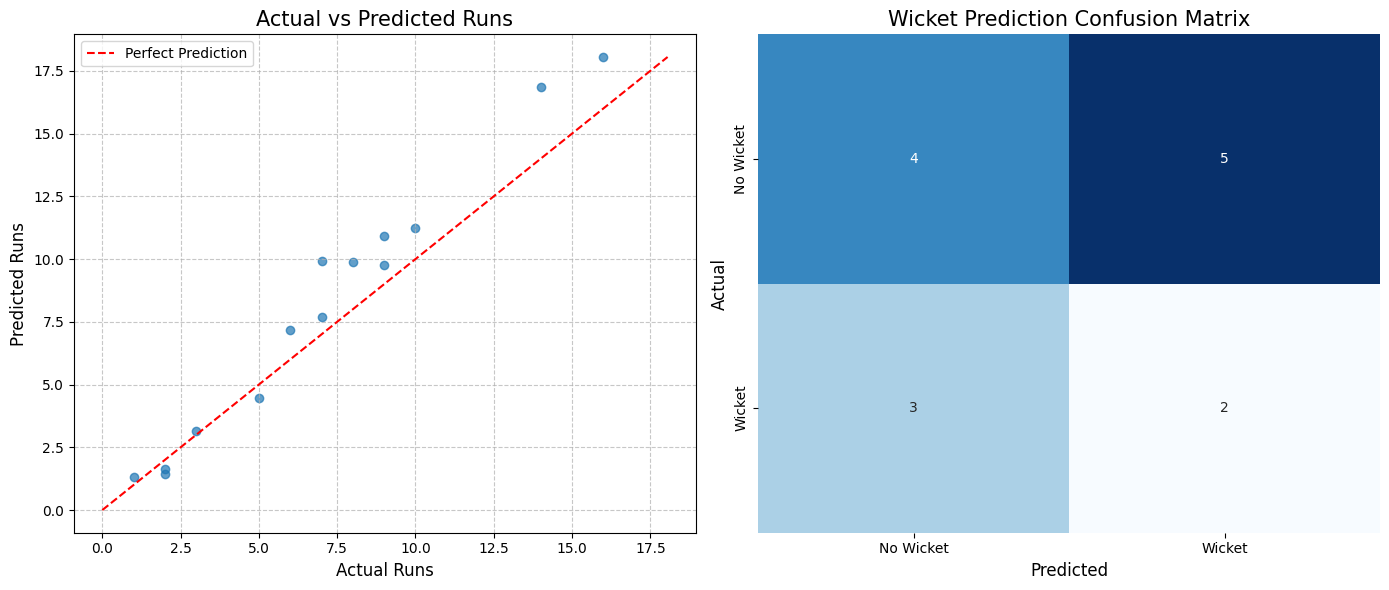

Saved predictions with actual values to 'predictions_with_actuals.csv'


In [219]:
def compare_with_actuals(predictions_df, input_df):
    """Compare predictions with actual values if available.
    
    Args:
        predictions_df: DataFrame with predictions
        input_df: Original input DataFrame
    """
    # Check if actual values are available
    if 'total_runs' in input_df.columns or 'is_wicket' in input_df.columns:
        print("\nComparing predictions with actual values:")
        
        # Add actual values to the predictions DataFrame
        if 'index' in predictions_df.columns:
            # Match by index
            for i, row in predictions_df.iterrows():
                idx = row['index']
                if 'total_runs' in input_df.columns:
                    predictions_df.at[i, 'actual_runs'] = input_df.iloc[idx]['total_runs']
                if 'is_wicket' in input_df.columns:
                    predictions_df.at[i, 'actual_wicket'] = input_df.iloc[idx]['is_wicket']
        elif 'match_id' in predictions_df.columns and 'inning' in predictions_df.columns and 'over' in predictions_df.columns:
            # Match by match_id, inning, over
            for i, row in predictions_df.iterrows():
                match_row = input_df[
                    (input_df['match_id'] == row['match_id']) & 
                    (input_df['inning'] == row['inning']) & 
                    (input_df['over'] == row['over'])
                ]
                if not match_row.empty:
                    if 'total_runs' in input_df.columns:
                        predictions_df.at[i, 'actual_runs'] = match_row['total_runs'].values[0]
                    if 'is_wicket' in input_df.columns:
                        predictions_df.at[i, 'actual_wicket'] = match_row['is_wicket'].values[0]
        
        # Calculate performance metrics
        if 'actual_runs' in predictions_df.columns:
            run_mae = (predictions_df['predicted_runs'] - predictions_df['actual_runs']).abs().mean()
            run_mse = ((predictions_df['predicted_runs'] - predictions_df['actual_runs']) ** 2).mean()
            print(f"Run Mean Absolute Error (MAE): {run_mae:.2f}")
            print(f"Run Mean Squared Error (MSE): {run_mse:.2f}")
            
        if 'actual_wicket' in predictions_df.columns:
            wicket_accuracy = (predictions_df['predicted_wicket'] == predictions_df['actual_wicket']).mean()
            print(f"Wicket Prediction Accuracy: {wicket_accuracy:.2%}")
            
        # Plot actual vs predicted if available
        if 'actual_runs' in predictions_df.columns:
            plt.figure(figsize=(14, 6))
            
            # Plot predicted vs actual runs
            plt.subplot(1, 2, 1)
            plt.scatter(predictions_df['actual_runs'], predictions_df['predicted_runs'], alpha=0.7)
            # Add y=x line
            max_val = max(predictions_df['actual_runs'].max(), predictions_df['predicted_runs'].max())
            plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')
            plt.title('Actual vs Predicted Runs', fontsize=15)
            plt.xlabel('Actual Runs', fontsize=12)
            plt.ylabel('Predicted Runs', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend()
            
            # If we have wicket data, plot confusion matrix
            if 'actual_wicket' in predictions_df.columns:
                from sklearn.metrics import confusion_matrix
                import seaborn as sns
                
                plt.subplot(1, 2, 2)
                cm = confusion_matrix(predictions_df['actual_wicket'], predictions_df['predicted_wicket'])
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
                plt.title('Wicket Prediction Confusion Matrix', fontsize=15)
                plt.xlabel('Predicted', fontsize=12)
                plt.ylabel('Actual', fontsize=12)
                plt.xticks([0.5, 1.5], ['No Wicket', 'Wicket'])
                plt.yticks([0.5, 1.5], ['No Wicket', 'Wicket'])
            
            plt.tight_layout()
            plt.show()
            
        # Save updated predictions with actual values
        predictions_df.to_csv('predictions_with_actuals.csv', index=False)
        print("Saved predictions with actual values to 'predictions_with_actuals.csv'")
        
        return predictions_df
    else:
        print("No actual values available for comparison")
        return predictions_df

# Compare with actual values if available
predictions_with_actuals = compare_with_actuals(predictions_df, input_df)

## Inference per Over: Predicted vs Actual

This cell loads input from `inference.csv`, runs inference using the saved model (loaded from `train/*/best_ipl_model.pth`), and displays a table showing each over's predictions together with actual values (if available).

Run inference for each over (row-wise) from `inference.csv` and display a table comparing predicted and actual runs.

In [220]:
# Load input data from inference.csv
df = input_df
if df is not None:
    # For per-over inference, use single instance mode
    processed_df, numerical_data = preprocess_input_data(df, numerical_features, scaler, team_encoder)
    model_inputs = prepare_model_inputs(processed_df, numerical_data, sequence_mode=False)
    predictions = run_inference(model, model_inputs['inputs'], model_inputs['metadata'], sequence_mode=False)
    
    # Create a DataFrame from predictions
    pred_df = pd.DataFrame(predictions)
    
    # If actual values are present, add them (assuming 'total_runs')
    if 'total_runs' in df.columns:
        pred_df['actual_runs'] = df['total_runs']
    
    # Show a table with over, predicted runs, and actual runs (if available)
    if 'over' in df.columns:
        result_table = pred_df[['over', 'predicted_runs', 'actual_runs']] if 'actual_runs' in pred_df.columns else pred_df[['over', 'predicted_runs']]
        print('Per Over Inference Results:')
        display(result_table)
    else:
        print('Over information not available in input data')
else:
    print('No input data found in inference.csv')

Scaled numerical features
Preparing individual inputs for each row
Prepared 14 individual inputs
Completed inference on 14 inputs
Per Over Inference Results:


,over,predicted_runs,actual_runs
0,1,1.425331,2
1,2,9.746565,9
2,3,1.329256,1
3,4,4.463590,5
4,5,1.623729,2
5,6,11.239925,10
6,7,9.902568,8
7,8,7.163647,6
8,9,10.916724,9
9,10,3.142189,3
